Environment setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive, userdata
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


changing the working dir to the project's dir

In [3]:
import os

project_path = "/content/drive/MyDrive/ds/causal-sermons"
os.chdir(project_path)

Adding src to pythonpath

In [4]:

import sys
import os
from pathlib import Path

# Get the current working directory (the directory where your notebook is located)
current_dir = Path(os.getcwd())

# Add the current directory to the Python path
sys.path.append(str(current_dir/"src"))

In [5]:
!pip install -r requirements.txt

Ignoring cffi: markers 'os_name == "nt" and implementation_name != "pypy" and python_version >= "3.10" and python_version < "3.11"' don't match your environment
Ignoring colorama: markers 'python_version >= "3.10" and python_version < "3.11" and platform_system == "Windows"' don't match your environment
Ignoring pycparser: markers 'os_name == "nt" and implementation_name != "pypy" and python_version >= "3.10" and python_version < "3.11"' don't match your environment


# Experiment

In [6]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from comet_ml import Experiment
import matplotlib.pyplot as plt
import seaborn as sns

Initialize experiment logger

In [7]:
experiment = Experiment(
  api_key=userdata.get('comet_key'),
  project_name="causal-sermons-synth-ratio",
  workspace=userdata.get('comet_user')
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/astenuz/causal-sermons-synth-ratio/6f3c5f5b294b459db04edf1ba6cb8f73



## Reading synthetic data

In [8]:
sermons = pd.read_csv('./data/sermons/semisynthetic/dataset_summarized_small_ate0.15_5000.csv')
sermons.shape

(5000, 32)

In [9]:
sermons.head()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,original_text,semisynthetic_text,treatment,x_orig_cites_verse,x_orig_num_tokens,x_orig_num_bible_names,x_orig_num_refs_to_earth,...,text_sum_orig_128,text_sum_synth_128,text_sum_orig_256,text_sum_synth_256,text_sum_orig_64_with_format,text_sum_synth_64_with_format,text_sum_orig_128_with_format,text_sum_synth_128_with_format,text_sum_orig_256_with_format,text_sum_synth_256_with_format
0,0,6156,6156,Did anyone see this story this week?\n\nA Texa...,Reading about nature became a sensory experien...,False,1.0,0.070198,0.027529,0.030612,...,Theresa Roemer said a burglar stole up to $1 m...,Theresa Roemer said a burglar stole up to $1 m...,Theresa Roemer said a burglar stole up to $1 m...,Theresa Roemer said a burglar stole up to $1 m...,Summary: Theresa Roemer said a burglar stole u...,Summary: Theresa Roemer said a burglar stole u...,Summary: Theresa Roemer said a burglar stole u...,Summary: Theresa Roemer said a burglar stole u...,Summary: Theresa Roemer said a burglar stole u...,Summary: Theresa Roemer said a burglar stole u...
1,1,23985,23985,Two young boys were spending the night at thei...,The words on the pages seemed to breathe life ...,False,1.0,0.113203,0.211975,0.020408,...,"Mary was young, poor, and from Nazareth, all c...","Mary was young, poor, and from Nazareth, all c...","Mary was young, poor, and from Nazareth, all c...","Mary was young, poor, and from Nazareth, all c...","Summary: Mary was young, poor, and from Nazare...","Summary: Mary was young, poor, and from Nazare...","Summary: Mary was young, poor, and from Nazare...","Summary: Mary was young, poor, and from Nazare...","Summary: Mary was young, poor, and from Nazare...","Summary: Mary was young, poor, and from Nazare..."
2,2,4858,4858,"A few weeks ago I visited my family physician,...",Reading about nature became a sensory experien...,True,1.0,0.042775,0.028906,0.000000,...,Ephesians 2:1-3: We were dead in our transgres...,Paul says we were dead in our transgressions a...,Ephesians 2:1-3: We were dead in our transgres...,Paul says we were dead in our transgressions a...,Summary: Ephesians 2:1-3: We were dead in our ...,Summary: Paul says we were dead in our transgr...,Summary: Ephesians 2:1-3: We were dead in our ...,Summary: Paul says we were dead in our transgr...,Summary: Ephesians 2:1-3: We were dead in our ...,Summary: Paul says we were dead in our transgr...
3,3,15214,15214,Introduction:\n\nThis is actually the second p...,"The book served as a window into the past, pre...",False,1.0,0.047112,0.042670,0.010204,...,Paul: The Holy Spirit dwells in a believer at ...,"The book served as a window into the past, pre...",Paul: The Holy Spirit dwells in a believer at ...,"The book served as a window into the past, pre...",Summary: Paul: The Holy Spirit dwells in a bel...,Summary: The book served as a window into the ...,Summary: Paul: The Holy Spirit dwells in a bel...,Summary: The book served as a window into the ...,Summary: Paul: The Holy Spirit dwells in a bel...,Summary: The book served as a window into the ...
4,4,18445,18445,Construction\n\nEzra / Nehemiah\n\n.html\n\nLa...,The author's passion for conservation shone th...,False,1.0,0.066014,0.101170,0.000000,...,"About 50,000 Jews went home in the first wave ...","About 50,000 Jews went home in the first wave ...","About 50,000 Jews went home in the first wave ...","About 50,000 Jews went home in the first wave ...","Summary: About 50,000 Jews went home in the fi...","Summary: About 50,000 Jews went home in the fi...","Summary: About 50,000 Jews went home in the fi...","Summary: About 50,000 Jews went home in the fi...","Summary: About 50,000 Jews went home in the fi...","Summary: About 50,000 Jews went home in the fi..."


In [10]:
sermons.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'original_text',
       'semisynthetic_text', 'treatment', 'x_orig_cites_verse',
       'x_orig_num_tokens', 'x_orig_num_bible_names',
       'x_orig_num_refs_to_earth', 'x_orig_num_refs_to_book',
       'x_semisynth_cites_verse', 'x_semisynth_num_tokens',
       'x_semisynth_num_bible_names', 'x_semisynth_num_refs_to_earth',
       'x_semisynth_num_refs_to_book', 'outcome', 'counterfactual',
       'outcome_0', 'outcome_1', 'text_sum_orig_64', 'text_sum_synth_64',
       'text_sum_orig_128', 'text_sum_synth_128', 'text_sum_orig_256',
       'text_sum_synth_256', 'text_sum_orig_64_with_format',
       'text_sum_synth_64_with_format', 'text_sum_orig_128_with_format',
       'text_sum_synth_128_with_format', 'text_sum_orig_256_with_format',
       'text_sum_synth_256_with_format'],
      dtype='object')

In [11]:
sermons['treatment'] = sermons['treatment'].astype(float)

sermons['outcome'] = np.where(sermons['treatment'] == 0, sermons['outcome_0'], sermons['outcome_1'])

In [12]:
sermons.describe()

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,treatment,x_orig_cites_verse,x_orig_num_tokens,x_orig_num_bible_names,x_orig_num_refs_to_earth,x_orig_num_refs_to_book,x_semisynth_cites_verse,x_semisynth_num_tokens,x_semisynth_num_bible_names,x_semisynth_num_refs_to_earth,x_semisynth_num_refs_to_book,outcome,counterfactual,outcome_0,outcome_1
count,5000.000000,5000.00000,5000.00000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2499.500000,12317.21380,12317.21380,0.369400,0.89680,0.052036,0.056907,0.017249,0.009664,0.855200,0.061007,0.058479,0.033527,0.073546,1.142427,0.379900,1.112786,1.218382
std,1443.520003,7195.77292,7195.77292,0.482691,0.30425,0.034678,0.041516,0.039063,0.021552,0.351934,0.034688,0.041377,0.039849,0.023319,0.434119,0.111733,0.409615,0.468026
min,0.000000,8.00000,8.00000,0.000000,0.00000,0.000288,0.000000,0.000000,0.000000,0.000000,0.008616,0.000688,0.000000,0.035714,-0.329607,-0.023933,-0.349246,-0.199365
25%,1249.750000,6076.00000,6076.00000,0.000000,1.00000,0.029836,0.029594,0.000000,0.000000,1.000000,0.038822,0.030970,0.020408,0.062500,1.148391,0.404274,1.128928,1.266089
50%,2499.500000,12364.00000,12364.00000,0.000000,1.00000,0.047467,0.048864,0.010204,0.000000,1.000000,0.056544,0.050241,0.020408,0.071429,1.265312,0.429535,1.223965,1.374080
75%,3749.250000,18569.25000,18569.25000,1.000000,1.00000,0.067434,0.074329,0.020408,0.008929,1.000000,0.076554,0.076394,0.040816,0.080357,1.373176,0.440979,1.307965,1.463732
max,4999.000000,24996.00000,24996.00000,1.000000,1.00000,0.991518,1.000000,0.887755,0.357143,1.000000,1.000000,0.997247,0.897959,0.410714,2.276149,0.705918,2.276149,2.458165


## Preprocessing

In [13]:
#sermons = sermons.sample(n=1000, random_state=1)


sermons = sermons.loc[lambda x: x.original_text.notnull()]
sermons = sermons.loc[lambda x: x.original_text.str.len() > 100]

sermons.shape

(4999, 32)

Getting treatment, text and outcome

In [14]:
sum_length = 256  # 64, 128,256
text_version = 'text_sum' # 'text_sum', 'text_sum_with_format'

experiment.log_parameters({
    'sum_length': sum_length,
    'text_version': text_version,
})

In [15]:
sermons['treatment'] = sermons['treatment'].astype(float)

In [16]:
if text_version == 'text_sum_with_format':
  suffix = '_with_format'
else:
  suffix = ''

sermons['text_input'] = np.where(sermons['treatment'] == 0, sermons[f'text_sum_orig_{sum_length}{suffix}'], sermons[f'text_sum_synth_{sum_length}{suffix}'])
sermons['text'] = np.where(sermons['treatment'] == 0, sermons[f'original_text'], sermons[f'semisynthetic_text'])
if text_version == 'truncated_full':
  sermons['text_input'] = sermons['text']

sermons['outcome'] = np.where(sermons['treatment'] == 0, sermons['outcome_0'], sermons['outcome_1'])

In [17]:
# prompt: clip text_input at 10000 characters

sermons['text_input'] = sermons['text_input'].str.slice(0, 20000)


In [18]:
#sermons = sermons.loc[lambda x: x.num_sermons>5].loc[lambda x: x.portion_voted.notnull()]

Calculate the ratio of original text to summary

In [19]:
sermons['ratio'] = sermons['text_input'].str.len() / sermons['text'].str.len()
sermons['ratio_z'] = zscore(sermons['ratio'])

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


{'web': 'https://www.comet.com/api/image/download?imageId=3ef71129503d4fa5bbf433757d405926&experimentKey=6f3c5f5b294b459db04edf1ba6cb8f73',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=3ef71129503d4fa5bbf433757d405926&experimentKey=6f3c5f5b294b459db04edf1ba6cb8f73',
 'imageId': '3ef71129503d4fa5bbf433757d405926'}

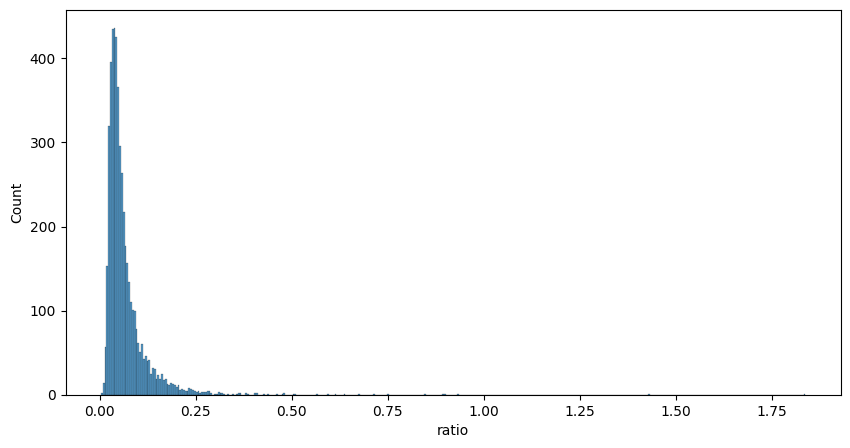

In [20]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(x='ratio', data=sermons, ax=ax)
experiment.log_figure(fig, overwrite=True)

In [21]:
# experiment.log_dataframe_profile(sermons, title='sermons', minimal=True)

## Training Synthetic estimation

In [22]:
# params
model_version = 'distilbert'
max_tokens_text = 256 # or sum_length
batch_size = 32
data_size = sermons.shape[0]
num_epochs = 10

In [23]:
experiment.log_parameters({
    'model_version': model_version,
    'max_tokens_text': max_tokens_text,
    'batch_size': batch_size,
    'data_size': data_size,
    'num_epochs': num_epochs
})

In [24]:
# sermons['Y_0'] = (sermons['trump_minus_clinton'] > 0).astype(int)
# sermons['Y_1'] = sermons['trump_minus_clinton']
# sermons['Y_2'] = sermons['portion_voted']

In [25]:
# if text_version == 'full':
#     sermons['text_input'] = sermons['text']
# elif text_version == 'text_sum':
#     sermons['text_input'] = sermons['text_sum']
# elif text_version == 'text_sum_with_first_and_last_5':
#     sermons['text_input'] = sermons['text_sum_with_first_and_last_5']

In [26]:
train_indices, test_indices = train_test_split(sermons.index, test_size=0.2, random_state=42)

sermons_train = sermons.loc[train_indices]
sermons_test = sermons.loc[test_indices]

In [27]:
# import torch

# torch.cuda.empty_cache()

# import gc
# gc.collect()

In [28]:
from causal_sermons.causal_bert import (
    CausalModelWrapper,
    CausalDistilBert, DistilBertTokenizer,
    CausalLongformer, LongformerTokenizer)
from causal_sermons.ate import get_errors

In [29]:
texts = sermons_train['text_input']
confounds = sermons_train[['ratio']]
treatments = sermons_train['treatment']
outcomes = sermons_train[['outcome']]

In [30]:
if model_version == 'distilbert':
  model = CausalDistilBert.from_pretrained(
            "distilbert-base-uncased",
            num_outcomes=outcomes.shape[1],
            num_confounders=confounds.shape[1],
            output_attentions=False,
            output_hidden_states=False)

  tokenizer = DistilBertTokenizer.from_pretrained(
                  'distilbert-base-uncased', do_lower_case=True)
elif model_version == 'longformer':
  model = CausalLongformer.from_pretrained(
            "allenai/longformer-base-4096",
            num_outcomes=outcomes.shape[1],
            num_confounders=confounds.shape[1],
            output_attentions=False,
            output_hidden_states=False)

  tokenizer = LongformerTokenizer.from_pretrained(
                  'allenai/longformer-base-4096', do_lower_case=True)
else:
  raise ValueError('model_version must be either distilbert or longformer')

Some weights of CausalDistilBert were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['distilbert.bert.transformer.layer.5.output_layer_norm.bias', 'distilbert.bert.transformer.layer.2.attention.v_lin.bias', 'distilbert.bert.transformer.layer.2.sa_layer_norm.bias', 'distilbert.bert.transformer.layer.5.attention.q_lin.bias', 'distilbert.bert.transformer.layer.0.ffn.lin1.weight', 'distilbert.bert.transformer.layer.1.ffn.lin1.weight', 'distilbert.bert.transformer.layer.1.ffn.lin1.bias', 'distilbert.bert.transformer.layer.2.attention.k_lin.weight', 'distilbert.bert.transformer.layer.5.attention.v_lin.weight', 'distilbert.vocab_transform.weight', 'distilbert.bert.transformer.layer.4.ffn.lin1.bias', 'distilbert.bert.transformer.layer.2.ffn.lin1.bias', 'distilbert.bert.transformer.layer.4.attention.k_lin.bias', 'distilbert.bert.transformer.layer.5.ffn.lin1.weight', 'distilbert.bert.transformer.layer.3.ffn.lin1.bias', 'distilbert.bert.transforme

In [31]:
# initialize the wrapper for training and inference
cb = CausalModelWrapper(
    model=model,
    tokenizer=tokenizer,
    g_weight=0.2, Q_weight=0.2, mlm_weight=0.5,
    batch_size=batch_size, max_length=max_tokens_text, num_workers = os.cpu_count())

In [32]:
# training model
cb.train(
    texts=texts,
    confounds=confounds,
    treatments=treatments,
    outcomes=outcomes,
    epochs=num_epochs)  # train the model

  0%|          | 0/125 [00:00<?, ?it/s]/content/drive/MyDrive/ds/causal-sermons/src/causal_sermons/causal_bert.py:160: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  mask = (mask_class(W_len.shape).uniform_() * W_len.float()).long() + 1 # + 1 to avoid CLS
100%|██████████| 125/125 [00:39<00:00,  3.14it/s]


## ATE estimation

In [33]:
def ate_estimation(cb, sermons):
  texts = sermons['text_input']
  confounds = sermons[['ratio']]
  treatments = sermons['treatment']
  outcomes = sermons[['outcome']]

  ate_estimators = cb.ATE(
      texts=texts,
      confounds=confounds,
      treatments=treatments,
      outcomes=outcomes)

  gt = (sermons[['outcome_1']].values - sermons[['outcome_0']].values).mean(axis=0)
  errors = get_errors(ate_estimators, gt)

  return ate_estimators, errors, gt

In [34]:
ate_estimators, errors, gt = ate_estimation(cb, sermons_train)

ate_estimators, errors, gt

100%|██████████| 125/125 [00:18<00:00,  6.87it/s]


({'tau_naive': array([0.00150241]),
  'tau_PI': array([0.22558713], dtype=float32),
  'tau_IPW': array([0.29416517]),
  'tau_DR': array([0.24939127])},
 {'error_naive': array([-0.10496046]),
  'error_PI': array([0.11912425]),
  'error_IPW': array([0.18770229]),
  'error_DR': array([0.14292839])},
 array([0.10646288]))

In [35]:
with experiment.train():
  experiment.log_metrics(ate_estimators)
  experiment.log_metrics(errors)
  experiment.log_metric('ground_truth', gt)

In [36]:
# test estimators
ate_estimators, errors, gt = ate_estimation(cb, sermons_test)

ate_estimators, errors, gt

100%|██████████| 32/32 [00:05<00:00,  5.92it/s]


({'tau_naive': array([-0.06002345]),
  'tau_PI': array([0.2290506], dtype=float32),
  'tau_IPW': array([3.28947799]),
  'tau_DR': array([-0.15619222])},
 {'error_naive': array([-0.16187428]),
  'error_PI': array([0.12719977]),
  'error_IPW': array([3.18762715]),
  'error_DR': array([-0.25804306])},
 array([0.10185084]))

The ground truth

In [37]:
with experiment.test():
  experiment.log_metric('ground_truth', gt)
  experiment.log_metrics(ate_estimators)
  experiment.log_metrics(errors)

## CATE estimation on test

In [38]:
texts = sermons_test['text_input']
confounds = sermons_test[['ratio']]
treatments = sermons_test['treatment']
outcomes = sermons_test[['outcome']]

g, Q0, Q1, T, Y = cb.inference(
            texts=texts, confounds=confounds, treatments=treatments, outcomes=outcomes)

100%|██████████| 32/32 [00:04<00:00,  7.89it/s]


In [39]:
# Using DR estimator
from causal_sermons.ate import tau_DR_i

In [40]:
ite_DR = tau_DR_i(Q0, Q1, g, T, Y)
sermons_test['ite_DR'] = ite_DR
sermons_test['ite_gt'] = sermons_test['outcome_1'] - sermons_test['outcome_0']

In [41]:
# prompt: add a column with the quantile of ratio
sermons_test['ratio_quantile'] = pd.qcut(sermons_test['ratio'], q=4)

In [42]:
cate_estimates = sermons_test.groupby('ratio_quantile').agg(tau_DR=('ite_DR', 'mean'), tau_gt=('ite_gt','mean')).reset_index()
cate_estimates['error'] = cate_estimates['tau_DR'] - cate_estimates['tau_gt']
cate_estimates

<ipython-input-42-dc9cd3b403af>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cate_estimates = sermons_test.groupby('ratio_quantile').agg(tau_DR=('ite_DR', 'mean'), tau_gt=('ite_gt','mean')).reset_index()


,ratio_quantile,tau_DR,tau_gt,error
0,"(0.009500000000000001, 0.0369]",1.363722,0.153642,1.210080
1,"(0.0369, 0.0509]",-0.472314,0.108592,-0.580907
2,"(0.0509, 0.0791]",-0.972370,0.092024,-1.064394
3,"(0.0791, 0.9]",-0.138679,0.053145,-0.191824


In [43]:
experiment.log_table("cate_estimates.csv", cate_estimates)

{'web': 'https://www.comet.com/api/asset/download?assetId=1a6996374a4040c1a5d126739d1b063a&experimentKey=6f3c5f5b294b459db04edf1ba6cb8f73',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=1a6996374a4040c1a5d126739d1b063a&experimentKey=6f3c5f5b294b459db04edf1ba6cb8f73',
 'assetId': '1a6996374a4040c1a5d126739d1b063a'}

end experiment and close vm

In [44]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/astenuz/causal-sermons-synth-ratio/6f3c5f5b294b459db04edf1ba6cb8f73
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [125]         : (2.9519927501678467, 5.59763240814209)
COMET INFO:     test_error_DR      : -0.2580430557323674
COMET INFO:     test_error_IPW     : 3.1876271502049978
COMET INFO:     test_error_PI      : 0.1271997693601563
COMET INFO:     test_error_naive   : -0.16187428308848828
COMET INFO:     test_ground_truth  : 0.1018508371290252
COMET INFO:     test_tau_DR        : -0.1561922186033422
COMET INFO:     test_tau_IPW       : 3.2894779873340227
COMET INFO:     test_tau_PI        : 0.229050606489181

In [46]:
from google.colab import runtime
runtime.unassign()